<a href="https://colab.research.google.com/github/arjygh/stocksandoptions/blob/AG-edit-after-DM's-df-tickers/stonks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Call Buy Indicator Code

In [1]:
%%capture capt

##### Importing all packages #####################################
# optional installations: 
!pip install yfinance --upgrade --no-cache-dir
!pip3 install pandas_datareader
!pip3 install matplotlib
!pip install trading-calendars

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

import timeit
import traceback

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

# import pandas_datareader.data as web
# from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import timedelta
import time
import ssl
from urllib import request
import trading_calendars as tc
import pytz

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
# yahoo_finance.pdr_override()
%matplotlib inline

## Defining Functions

In this section functions for several technical indicators are coded:
1. RSI 
2. Stochastic Slow
3. MACD

In [2]:
def computeRSI(dataframe, time_window):
    
    '''RSI = Relative Strength Index (https://www.investopedia.com/terms/r/rsi.asp)'''
    
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics(dataframe, low, high, close, k, d):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    
    """
    EMA = exponential moving average
    MACD = Moving Average Convergence Divergence = 12Period EMA - 26Period EMA
    Signal  = 9Period EMA of MACD
    
    https://www.investopedia.com/terms/m/macd.asp
    
    """
    
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
    return df

def CBI_func(ticker, ticker_df, test_days, holding_days, vol_cutoff, vol_avg_window, 
             RSI_trend_days, RSI_low, RSI_hi, MACD_Div_trend_days, d_slow_trend_days, d_slow_low, d_slow_hi):
    """
    ticker - S&P500 ticker for which stock prices are obtained
    start_time - earliest date at which the stock_price is obtained from yfinance
    end_time - latest date at which the stock price is obtained from yfinance
    trade_date - a date between the start_time and end_time at which a hypothetical trade is entered

    All Technical Indicators are calculated with the "PAST" data and Price changes are calculated with the "FUTURE" data as defined below:
    start_time........................trade_date..........................end_time
    [..............PAST..............]          [...........FUTURE...............]

    CBI [Cumulative Buying Index]:
    - Average of scores calculated from value on trade date, slope and intercept of 'x' days before the trade date of the following Indicators: 
      - Stochastic slow - 14 day average
      - MACD Divergence - standard 12,26,9 day
    - Values closer to zero are strong indicators and the distance from zero defines the strength of the indicator, however, within small intervals 
      distance from zero may not necessarily correlate with strength. For eg: 
        - CBI of 0.1 and 0.5 is highly likely to indicate strong and weak buy respectively
        - CBI of 0.1 and 0.15 may not indicate that the former is a stronger buy than the latter

    """
    df0 = ticker_df
    
    # Call functions to calculate the Technical Indicators for each date (row) in the dataframe,...
    # append as columns to the same dataframe
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0, 'Close', 12, 26, 9)
    # df0 = slope(df0,3,'RSI')
    df0['RSI_slope'] = df0['RSI'].diff(RSI_trend_days)/RSI_trend_days
    df0['d_slow_slope'] = df0['d_slow'].diff(d_slow_trend_days)/d_slow_trend_days
    df0['MACD_Div_slope'] = df0['MACD_Div'].diff(d_slow_trend_days)/d_slow_trend_days

    print(df0)
    df0['avg_volume'] = df0.iloc[:,6].rolling(window=vol_avg_window).mean()
    

    passed_trades = pd.DataFrame()
    
    # intializing dataframe
    column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                    'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                    'MSCD_Div_val', 'MACD_Div_slope, intercept']
    

    df0['Price_Delta'] = (df0['Close'].rolling(holding_days).max().shift(-holding_days+1) - df0['Close'])/df0['Close']*100.
    df0['Price_Delta'] = np.where(df0['Price_Delta']<=0., 
                                        (df0['Close'].rolling(holding_days).min().shift(-holding_days+1) 
                                         - df0['Close'])/df0['Close']*100., df0['Price_Delta'])
    
    # Get NYSE Calendar
    xnys = tc.get_calendar("XNYS")

    for trade_date in test_days:
        if xnys.is_session(pd.Timestamp(trade_date, tz='UTC')):
            # Date to enter a trade
            day0 = trade_date
            day_past_MACD = day0 + timedelta(days = MACD_Div_trend_days)

            CBIL = [] #Call Buying Indicator List
    
            #trade date values
            RSI_val = df0[df0['Date']==day0]['RSI'].values
            MACD_Div_val = df0[df0['Date']==day0]['MACD_Div'].values
            d_slow_val = df0[df0['Date']==day0]['d_slow'].values
            avg_volume = df0[df0['Date']==day0]['avg_volume'].values
            price_delta = df0[df0['Date']==day0]['Price_Delta'].values
            trade_date_price = df0[df0['Date']==day0]['Close'].values
            RSI_slope = df0[df0['Date']==day0]['RSI_slope'].values
            MACD_Div_slope = df0[df0['Date']==day0]['MACD_Div_slope'].values
            d_slow_slope = df0[df0['Date']==day0]['d_slow_slope'].values
            MACD_Div_val_prev = df0[df0['Date']==day_past_MACD]['MACD_Div'].values

    
            #slopes
            # Extract location of date
            # j = df0.loc[(df0["Date"] == day0)].index.item()
            # RSI_fit = slope_calculator(df0[j-RSI_trend_days:j+1], RSI_trend_days, day0, 'RSI') #num_days >=3
            # MACD_Div_fit = slope_calculator(df0[j-MACD_Div_trend_days:j+1], MACD_Div_trend_days, day0, 'MACD_Div') #num_days >=3
            # d_slow_fit = slope_calculator(df0[j-d_slow_trend_days:j+1], d_slow_trend_days, day0, 'd_slow') #num_days >=3
    
            # Vol and RSI crieria
            if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_slope > 0:
                CBIL.append(day0)
    
                # TECHNICAL INDICATORS ALGEBRA #
                if d_slow_val > d_slow_low and d_slow_val < d_slow_hi and d_slow_slope > 0:
                    CBIL.append((abs(d_slow_val - 0.5*(d_slow_hi + d_slow_low))/(0.5*(d_slow_hi - d_slow_low))).item())
                else: 
                    CBIL.append(10.0)
    
                if MACD_Div_val < 0 and MACD_Div_val_prev < 0 and MACD_Div_slope > 0:
                    CBIL.append((MACD_Div_val/MACD_Div_val_prev).item())
                else: 
                    CBIL.append(10.0)

      
                CBIL.append(trade_date_price)
                CBIL.append(price_delta)
                CBI = 0.5*(CBIL[1] + CBIL[2])
                CBIL.append(CBI)
                
                if CBIL[5] < 1.0:
                    output = [ticker, CBIL[0], CBIL[1], CBIL[2], CBIL[5], CBIL[3].item(), CBIL[4].item(), 
                              avg_volume, RSI_val.item(), RSI_slope, d_slow_val.item(), d_slow_slope, MACD_Div_val.item(), MACD_Div_slope]
                    passed = pd.DataFrame([output], columns=column_names)
                    passed_trades = passed_trades.append(passed, ignore_index = True)
        
            
    return passed_trades
  

## Main Code - Testing for 1 Ticker

In [6]:
def connect_and_get_cbi_for_dataframe(ticker, dataframe, test_days):
    """
    Call CBI function to get relevant data
    """
    # Get Stock Prices for the ticker between start_time and end_time

    try:
        dataframe.reset_index(inplace=True)

        output = CBI_func(ticker, dataframe, test_days, holding_days = 15, vol_cutoff = 2.0e6, 
                          vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                          d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
        return output
    except Exception as e:
        print('Analyzed Security: ', ticker_list, 'No Data')
        traceback.print_exc()
        return pd.DataFrame()

def connect_and_get_cbi_for_ticker_list(ticker_list, start_time_for_fin_data, end_time_for_fin_data, test_days):
    """
    Connect with Yahoo Finance API first to fetch the data within the test_days period
    Returns a filled data frame if available, else an empty dataframe
    """
    # Get Stock Prices for the ticker between start_time and end_time
    tickers_ssv = ' '.join(ticker_list)
    print("Fetching tickers for ", tickers_ssv)
    start = timeit.default_timer()
    ticker_df = yahoo_finance.download(tickers_ssv, start=start_time, end=end_time, group_by="ticker", threads=True)
    print("Fetching tickers took seconds: ", timeit.default_timer() - start)

    no_data_tickers = []
    passed_trades = pd.DataFrame()

    # If it is a single ticker call, no need to extract the ticker from dataframe
    if len(ticker_list) <= 1:
        output = connect_and_get_cbi_for_dataframe(ticker_list[0], ticker_df, test_days)
        if output.empty:
            no_data_tickers.append(ticker_list[0])
        return output, no_data_tickers

    for ticker in ticker_list:
        output = connect_and_get_cbi_for_dataframe(ticker,  ticker_df[ticker], test_days)
        if output.empty:
            no_data_tickers.append(ticker)
        else:       
            passed_trades = passed_trades.append(output, ignore_index = True)
    return passed_trades, no_data_tickers


TEST CODE: In this section, a single ticker is analyzed for a range of dates

In [7]:
%%capture capt

no_data_tickers = []
ticker_list = ["MMM"]

# start_time and end_time to fetch data from yahoo
start_time = '2019-11-14'
end_time = '2021-04-01'

# start and end dates of trading period
_trade_days_start = '2020-01-01'
_trade_days_end = '2020-01-10'

test_days = pd.bdate_range(_trade_days_start, _trade_days_end)

output, no_data_tickers = connect_and_get_cbi_for_ticker_list(ticker_list, start_time, end_time, test_days)     
output.head()

Fetching tickers for  MMM
[*********************100%***********************]  1 of 1 completed
Fetching tickers took seconds:  0.38204402900001355
          Date        Open        High         Low       Close   Adj Close   Volume        RSI     k_fast     d_fast     k_slow     d_slow     d_div  MACD line  Sig Line  MACD_Div  RSI_slope  d_slow_slope  MACD_Div_slope
0   2019-11-14  169.979996  172.320007  169.929993  170.929993  162.044067  1613900        NaN        NaN        NaN        NaN        NaN       NaN   0.000000  0.000000  0.000000        NaN           NaN             NaN
1   2019-11-15  171.660004  172.690002  171.039993  171.880005  162.944687  2616900        NaN        NaN        NaN        NaN        NaN       NaN   0.075784  0.015157  0.060628        NaN           NaN             NaN
2   2019-11-18  170.789993  171.199997  169.169998  170.539993  161.674347  2364600        NaN        NaN        NaN        NaN        NaN       NaN   0.027401  0.017606  0.009795        NaN

""


## MAIN CODE - Full SP500

In [20]:
%%capture capt

url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
sp500 = sp500[['Symbol','Security','GICS Sector']]
sector_list = list(sp500['GICS Sector'].unique())
print(sector_list)
sp500.head(5)

In [ ]:
%%capture capt

# dropping tickers with . like BRK.B
sp500 = sp500[sp500['Symbol'] != "."]

no_data_tickers = []

# intializing dataframe
column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                'MSCD_Div_val', 'MACD_Div_slope, intercept']

passed_trades = pd.DataFrame()

# start_time and end_time to fetch data from yahoo
start_time = '2019-10-01'
end_time = '2021-04-18'

# start and end dates of trading period
trade_days_start = '2019-04-12'
trade_days_end = '2021-04-16'
test_days = pd.bdate_range(trade_days_start, trade_days_end)

sector_list = list(sp500['GICS Sector'].unique())
total = sp500['Symbol'].nunique()

sector_list = ['Energy']
#ticker_list = ['APA']

for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    passed_trades_df, no_data_tickers_list =  connect_and_get_cbi_for_ticker_list(ticker_list, start_time, end_time, test_days)
    print("Passed df for ", ticker_list)
    print(passed_trades_df)
    print("Done passed df")
    passed_trades = passed_trades.append(passed_trades_df)
    no_data_tickers.append(no_data_tickers_list)

if not passed_trades.size:
    raise Exception("No passed trades  found")

passed_trades = passed_trades.merge(sp500, how='left', on='Symbol')
passed_trades.head()

run_time = datetime.datetime.now().date().isoformat()
filename = 'sp500_passed_trades2018'+str(run_time)+'.csv'
passed_trades.to_csv(filename)
#sp500.to_csv('sp500.csv')

In [10]:
passed_trades.sort_values(by=['Trade_Date', 'CBI'], ascending=False, inplace=True)
passed_trades[passed_trades['CBI']<0.30].head(15)

,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept",Security,GICS Sector
27,EOG,2020-09-18,0.108118,0.011767,0.059942,40.709999,-14.492748,[5681428.571428572],41.663315,[0.6200210639585251],27.837640,[3.786876187631907],-0.000841,[0.12461703305191801],EOG Resources,Energy
57,NOV,2020-09-17,0.067732,0.084328,0.076030,11.850000,-26.919835,[4344385.714285715],49.949046,[1.4461313837901457],31.354648,[4.351636760193238],-0.003027,[0.02711916572719719],NOV Inc.,Energy
5,APA,2020-09-04,0.047487,0.516853,0.282170,14.600000,-32.534246,[6281114.285714285],48.598731,[0.7193683487060686],30.949740,[2.45931059389084],-0.091472,[0.0073024047593598165],APA Corporation,Energy
64,OXY,2020-08-10,0.319689,0.048964,0.184327,16.480000,-21.359221,[21592357.14285714],50.008542,[1.0215323703196637],23.606214,[2.152261709002296],-0.005237,[0.026888372905771896],Occidental Petroleum,Energy
25,EOG,2020-07-06,0.052838,0.547135,0.299987,50.410000,0.019834,[3361257.1428571427],47.186277,[0.7107537253138473],28.943232,[4.212384007837455],-0.412920,[0.10340354283061212],EOG Resources,Energy


## Plots

,Unnamed: 0,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept",Security,GICS Sector
0,0,APA,2020-02-06,0.571035,1.134891,0.852963,28.940001,-15.583967,[4537857.14285714],52.887552,[0.38262746],18.579297,[3.25792216],-0.485332,[0.07787881],APA Corporation,Energy
1,1,APA,2020-02-07,0.311115,1.198936,0.755026,28.110001,1.672000,[4345500.],47.629217,[0.11054772],23.777703,[4.03567505],-0.455467,[0.0824804],APA Corporation,Energy
2,2,APA,2020-02-20,0.713499,0.712364,0.712931,28.580000,-71.133660,[3050485.71428571],51.903741,[0.73135617],44.269976,[2.71258265],-0.123398,[0.04306909],APA Corporation,Energy
3,3,APA,2020-07-06,0.357183,0.869133,0.613158,13.530000,10.125646,[13046714.28571429],51.153303,[0.37837095],22.856343,[0.08496084],-0.185830,[0.01330804],APA Corporation,Energy
4,4,APA,2020-08-31,0.444375,1.319328,0.881851,14.800000,0.945942,[5375885.71428571],50.130257,[0.2479007],21.112498,[3.23063115],-0.120682,[0.02152013],APA Corporation,Energy


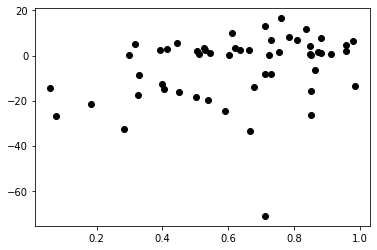

In [12]:
passed_trades = pd.read_csv(filename)
x = passed_trades['CBI']
y = passed_trades['Price_Delta'].values
plt.plot(x,y,'o', color='black')
passed_trades.head(5)

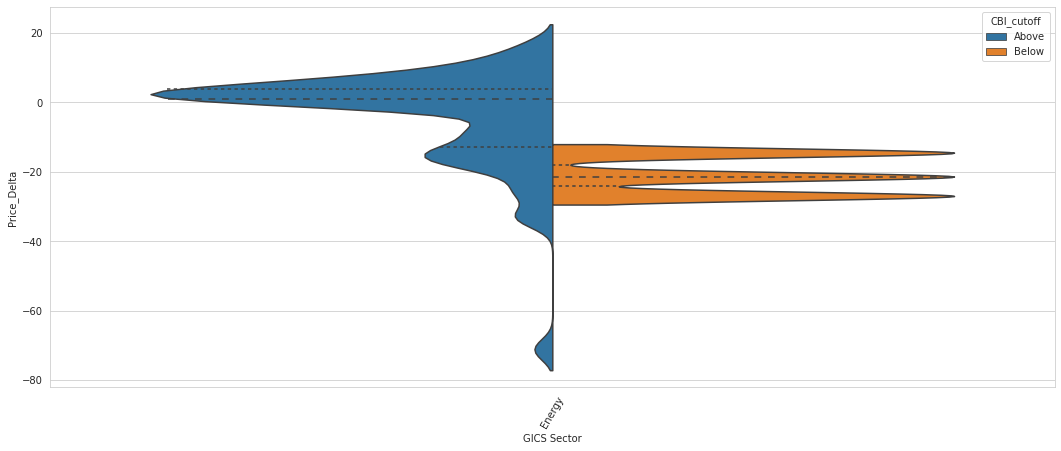

In [13]:
CBI_limit = 0.25
passed_trades['CBI_cutoff'] = np.where(passed_trades['CBI']<=CBI_limit, 'Below', 'Above')
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="Price_Delta", data=passed_trades, 
                  inner="quartile", split=True, hue='CBI_cutoff', scale='width', bw=0.2)

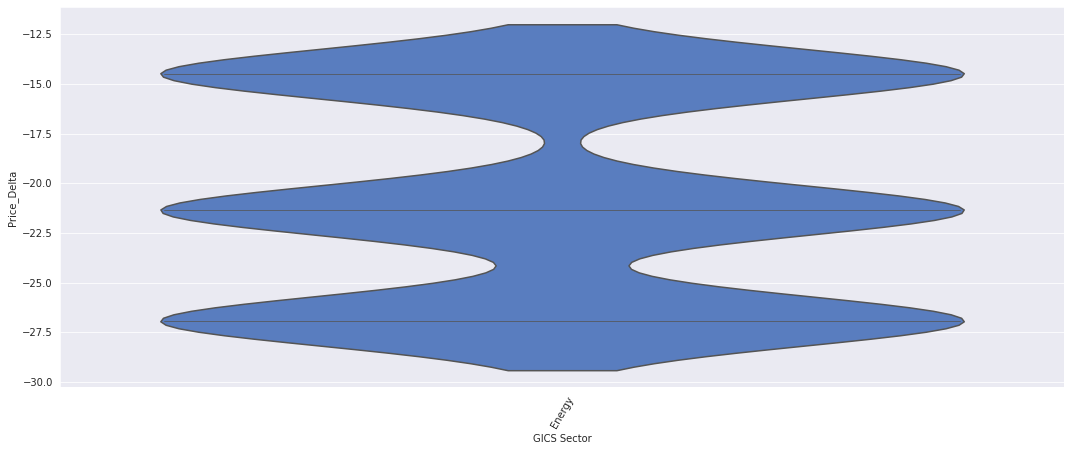

In [14]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="Price_Delta", data=passed_trades[passed_trades['CBI']<=CBI_limit], 
                  inner="sticks", scale='count', bw=0.2, palette='muted')


In [15]:
CBI_limit = .25
passed_trades_limit = passed_trades[passed_trades['CBI']<=CBI_limit]
passed_trades['Profit or Loss'] = np.where(passed_trades['Price_Delta']>0., 'Profit', 'Loss')

data = passed_trades_limit.groupby("Profit or Loss").agg({'Profit or Loss': ['count'], 'Price_Delta': 'mean'})
data.plot.pie(y='Profit or Loss', autopct="%.1f%%");
print(data)
data.reset_index(inplace=True)
print("Expected norm return = ",(data.iloc[1,1]*data.iloc[1,2]+data.iloc[0,1]*data.iloc[0,2])/(data.iloc[1,1]+data.iloc[0,1]),"% in 3 weeks")
print("Expected total return = ",(data.iloc[1,1]*data.iloc[1,2]/100+data.iloc[0,1]*data.iloc[0,2]/100),"investement = ", (data.iloc[1,1]+data.iloc[0,1]))

KeyError: ignored

In [ ]:

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="CBI", data=passed_trades, hue='Profit or Loss',
                  inner="quartile", scale='width', bw=0.2, palette='muted', split=True)